In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(1)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Correct file path
file_path = '/content/drive/My Drive/Colab Notebooks/Maga/Datasets/requests_every_hour.csv'

# Load the sequence data from CSV
requests = pd.read_csv(file_path, header=0)

# Review loaded data
print(requests)


Mounted at /content/drive
     Requests
0         100
1         113
2         162
3         186
4         228
..        ...
835       122
836       108
837        51
838        68
839        41

[840 rows x 1 columns]


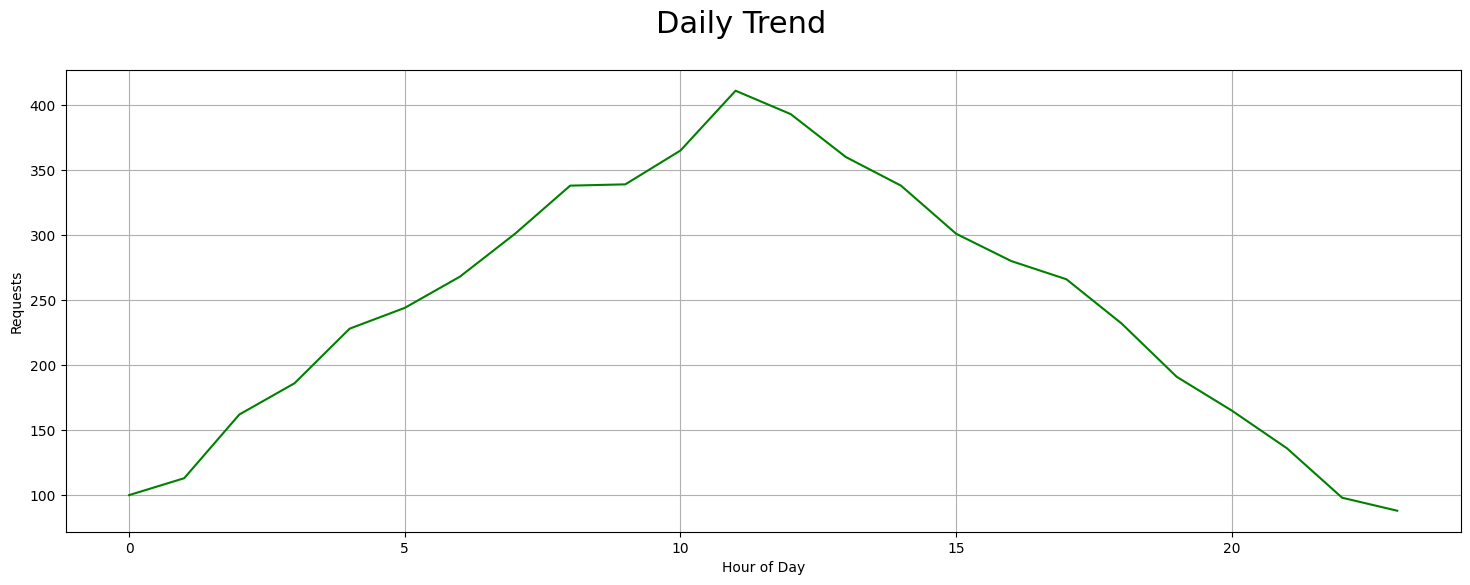

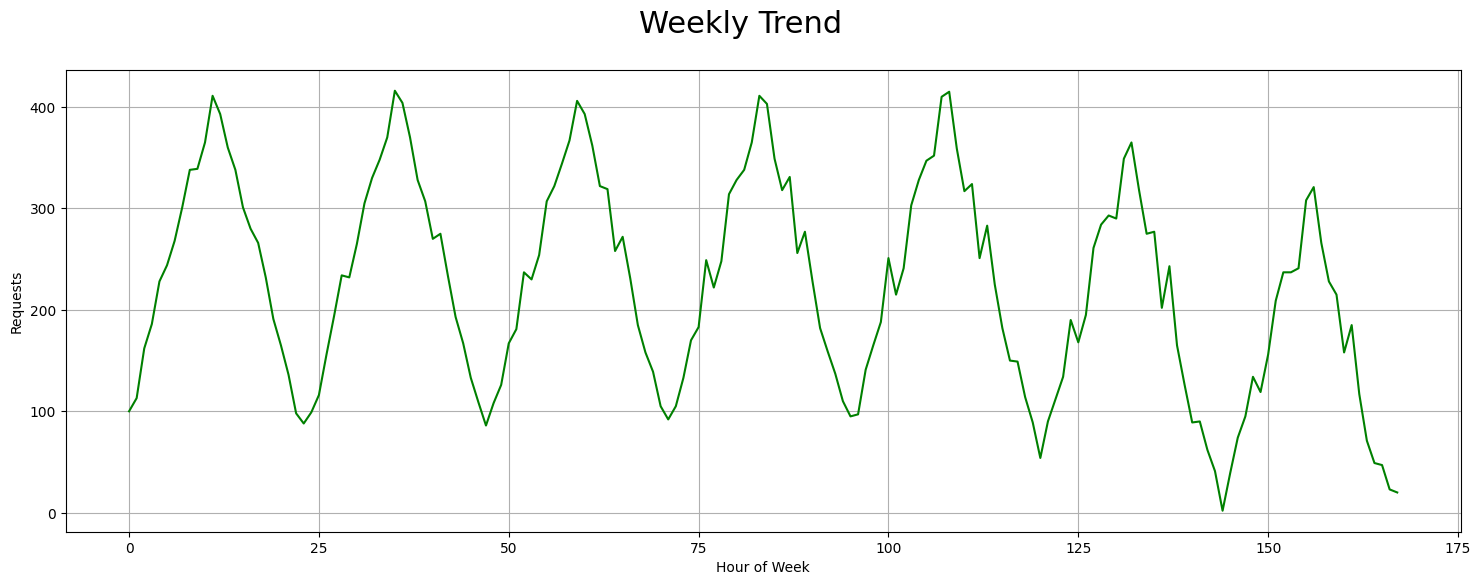

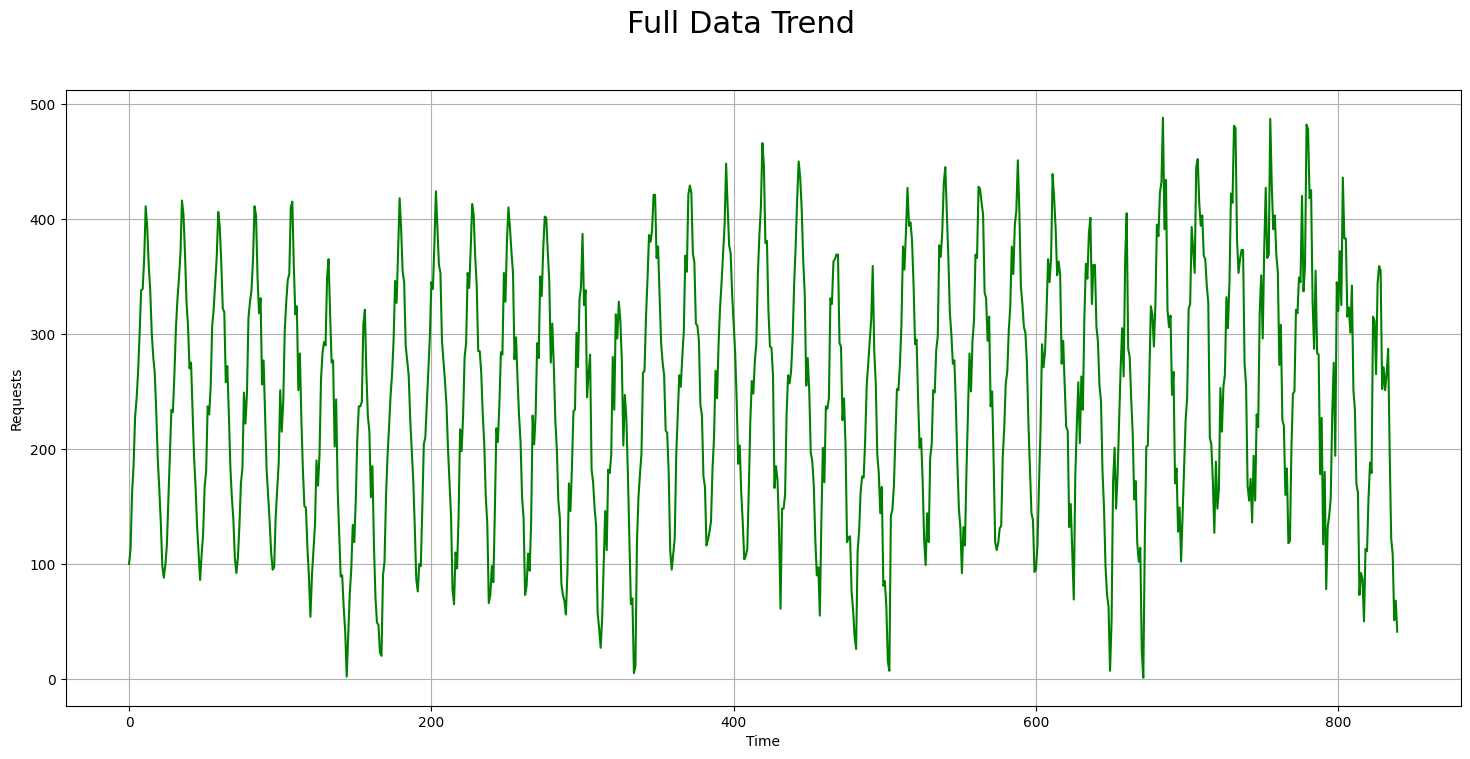

In [ ]:
#Plot the data loaded to visualize trends
# Daily pattern
plt.figure(figsize=(18, 6)).suptitle("Daily Trend", fontsize=22)
plt.plot(requests[:24], color='green')
plt.xlabel('Hour of Day')
plt.ylabel('Requests')
plt.grid(True)
plt.show()

# Weekly pattern
plt.figure(figsize=(18, 6)).suptitle("Weekly Trend", fontsize=22)
plt.plot(requests[:168], color='green')
plt.xlabel('Hour of Week')
plt.ylabel('Requests')
plt.grid(True)
plt.show()

# Full data
plt.figure(figsize=(18, 8)).suptitle("Full Data Trend", fontsize=22)
plt.plot(requests, color='green')
plt.xlabel('Time')
plt.ylabel('Requests')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Check request range before scaling
print("Initial request range:",
      requests.Requests.min(),
      requests.Requests.max())

# Standardize data
scaler = StandardScaler()
normalized_requests = scaler.fit_transform(requests)

# Check request range after scaling
print("Normalized request range:",
      normalized_requests.min(),
      normalized_requests.max())

# Define training data size (4 weeks) and lookback period (1 week)
train_size = 24 * 7 * 4
lookback_period = 24 * 7

# Split into training and testing sets
train_data = normalized_requests[:train_size]
test_data = normalized_requests[train_size - lookback_period:]

print("Train/Test shapes:", train_data.shape, test_data.shape)


Initial request range: 1 488
Normalized request range: -2.282212823208834 2.2374886819821467
Train/Test shapes: (672, 1) (336, 1)


In [ ]:
# Function to create dataset for RNN training
def generate_rnn_data(data, lookback=1):
    x_data, y_data = [], []
    for i in range(len(data) - lookback - 1):
        # Slice data for input features
        x_data.append(data[i:(i + lookback), 0])
        # Target value is the next point
        y_data.append(data[i + lookback, 0])
    return np.array(x_data), np.array(y_data)

# Generate training input (X) and target output (Y)
train_x, train_y = generate_rnn_data(train_data, lookback_period)

# Reshape X to match LSTM input requirements
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1])

# Output shapes of training data
print("Training data shapes: X =", train_x.shape, ", Y =", train_y.shape)


Training data shapes: X = (503, 1, 168) , Y = (503,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# Set a random seed for reproducibility
tf.random.set_seed(42)

# Initialize the LSTM model
model = Sequential()
# Add LSTM layer
model.add(LSTM(units=512, input_shape=(1, lookback_period)))
# Add output layer
model.add(Dense(units=1))

# Compile the model using Adam optimizer and mean squared error as the loss function
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

# Display the model architecture
model.summary()

# Train the model with training data
model.fit(train_x, train_y, epochs=5, batch_size=16, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 512)                 │       1,394,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,395,201 (5.32 MB)

 Trainable params: 1,395,201 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.3716 - mse: 0.3716
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0679 - mse: 0.0679
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0547 - mse: 0.0547
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0454 - mse: 0.0454
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0443 - mse: 0.0443


In [ ]:
ts_model.save('model3.h5')

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.13.0


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
from tensorflow.keras.models import load_model

ts_model = load_model('model2.h5')

In [ ]:
# Preprocess the test dataset to match the structure of the training set
test_x, test_y = generate_rnn_data(test_data, lookback_period)
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

# Evaluate the model on the test data
evaluation_metrics = model.evaluate(test_x, test_y, verbose=1)

# Make predictions on training data
train_predictions = model.predict(train_x)
# Make predictions on test data
test_predictions = model.predict(test_x)

# Reverse the scaling to interpret the predictions in the original scale
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1336 - mse: 0.1336  
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


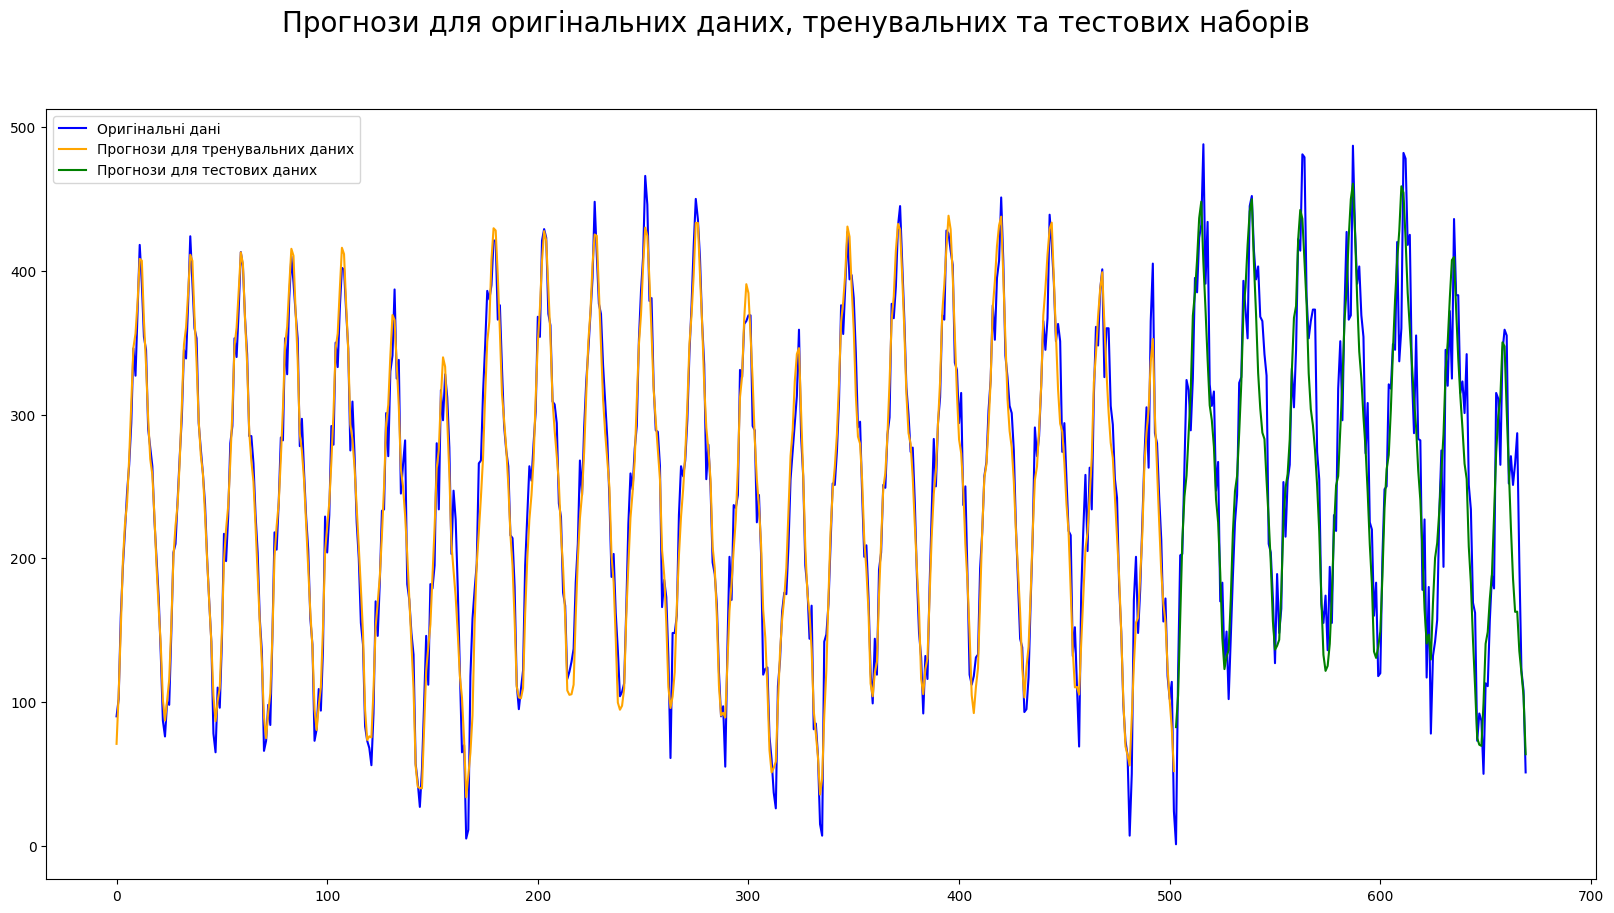

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Розмір загального графіку
total_size = len(train_predictions) + len(test_predictions)

# Оригінальні дані
original_data = requests.Requests.to_numpy()
original_data = original_data.reshape(len(original_data), 1)

# Створення масиву для оригінальних даних на графіку
original_plot = np.empty((total_size, 1))
original_plot[:, :] = np.nan
original_plot[0:total_size, :] = original_data[lookback_period:-2, :]

# Створення масиву для прогнозів на тренувальних даних
train_predictions_plot = np.empty((total_size, 1))
train_predictions_plot[:, :] = np.nan
train_predictions_plot[0:len(train_predictions), :] = train_predictions

# Створення масиву для прогнозів на тестових даних
test_predictions_plot = np.empty((total_size, 1))
test_predictions_plot[:, :] = np.nan
test_predictions_plot[len(train_predictions):total_size, :] = test_predictions

# Побудова графіків
plt.figure(figsize=(20, 10))
plt.suptitle("Прогнози для оригінальних даних, тренувальних та тестових наборів", fontsize=20)
plt.plot(original_plot, label="Оригінальні дані", color='blue')
plt.plot(train_predictions_plot, label="Прогнози для тренувальних даних", color='orange')
plt.plot(test_predictions_plot, label="Прогнози для тестових даних", color='green')

# Додавання легенди та показ графіка
plt.legend()
plt.show()


In [ ]:
# Start by using the last part of the test data as the initial input
current_input = test_x[-1, :].flatten()

# Define the number of steps to predict (next week, 24 hours per day * 7 days)
forecast_steps = 24 * 7

# Iterate to generate predictions for the next week
for step in range(forecast_steps):

    # Use the last 'lookback_period' number of samples as input for prediction
    input_for_prediction = current_input[-lookback_period:]

    # Reshape the input for the model
    input_for_prediction = input_for_prediction.reshape((1, 1, lookback_period))

    # Get the prediction for the next step
    next_prediction = model.predict(input_for_prediction)

    # Append the prediction to the input for the next iteration
    current_input = np.append(current_input, next_prediction.flatten())

# Extract the last 'forecast_steps' values, which represent the new predictions
future_predictions = np.reshape(np.array(current_input[-forecast_steps:]), (forecast_steps, 1))

# Inverse the scaling to view the results in original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Print the first 5 predictions for preview
print(future_predictions[:5])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

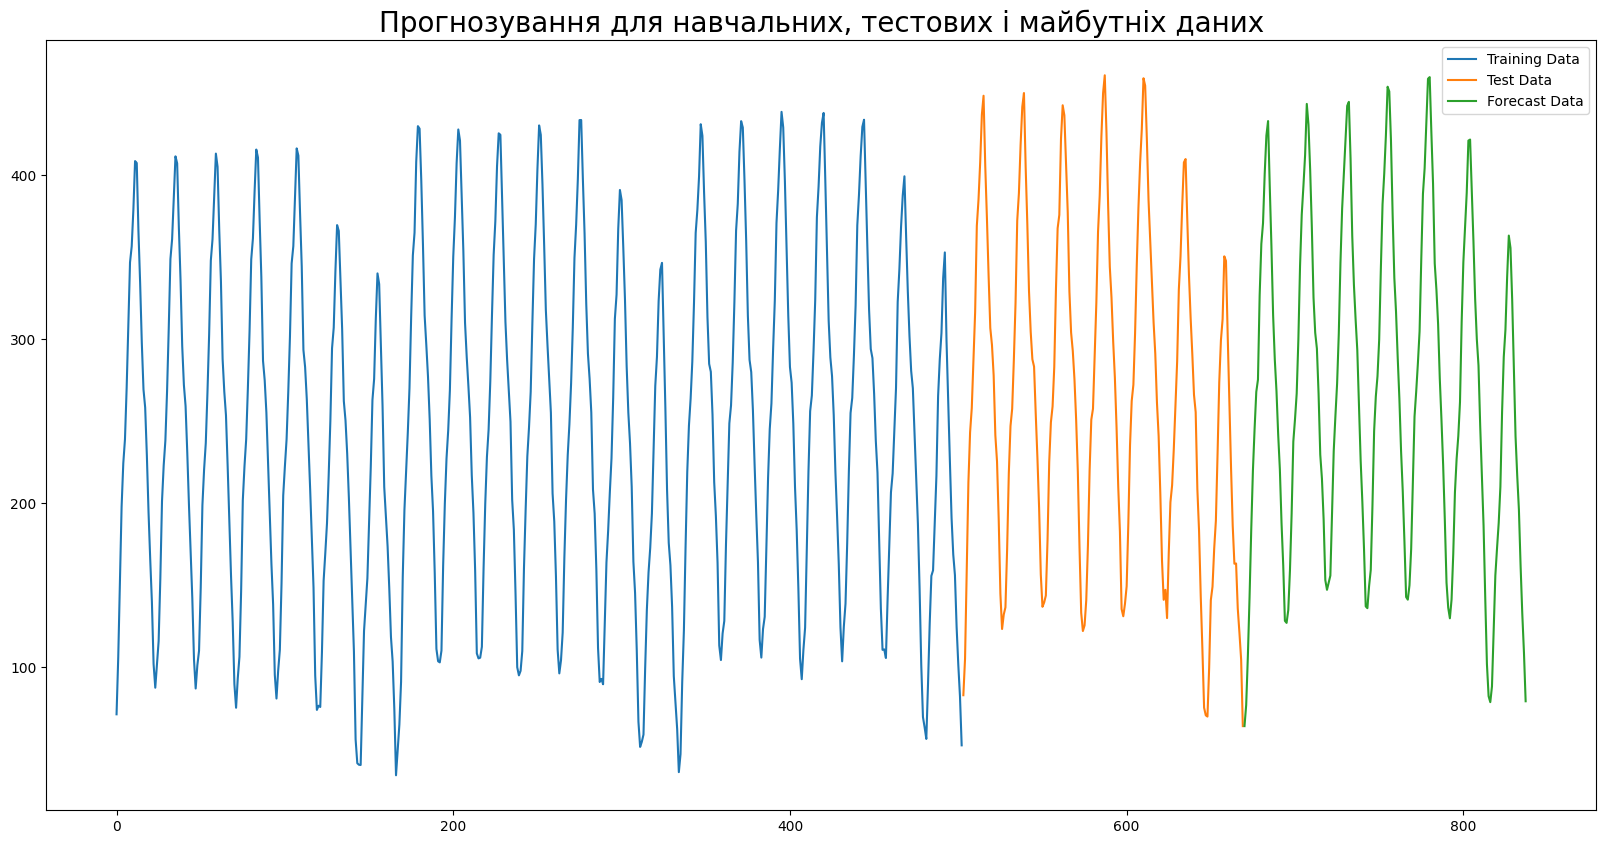

In [ ]:
# Відображення графіка даних навчання, тестування та прогнозу
full_length = len(train_predictions) + len(test_predictions) + len(future_predictions)

# Графік даних навчання
train_predictions_plot = np.full((full_length, 1), np.nan)
train_predictions_plot[:len(train_predictions), :] = train_predictions

# Графік даних тестування
test_predictions_plot = np.full((full_length, 1), np.nan)
test_predictions_plot[len(train_predictions):len(train_predictions) + len(test_predictions), :] = test_predictions

# Графік даних прогнозу
future_predictions_plot = np.full((full_length, 1), np.nan)
future_predictions_plot[len(train_predictions) + len(test_predictions):, :] = future_predictions

# Побудова графіка
plt.figure(figsize=(20, 10))
plt.title("Прогнозування для навчальних, тестових і майбутніх даних", fontsize=20)
plt.plot(train_predictions_plot, label="Training Data")
plt.plot(test_predictions_plot, label="Test Data")
plt.plot(future_predictions_plot, label="Forecast Data")
plt.legend()
plt.show()


#Create Dataset

<ipython-input-1-c837b379df6c>:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_interval = pd.date_range(start=start_time, periods=time_steps, freq='T')


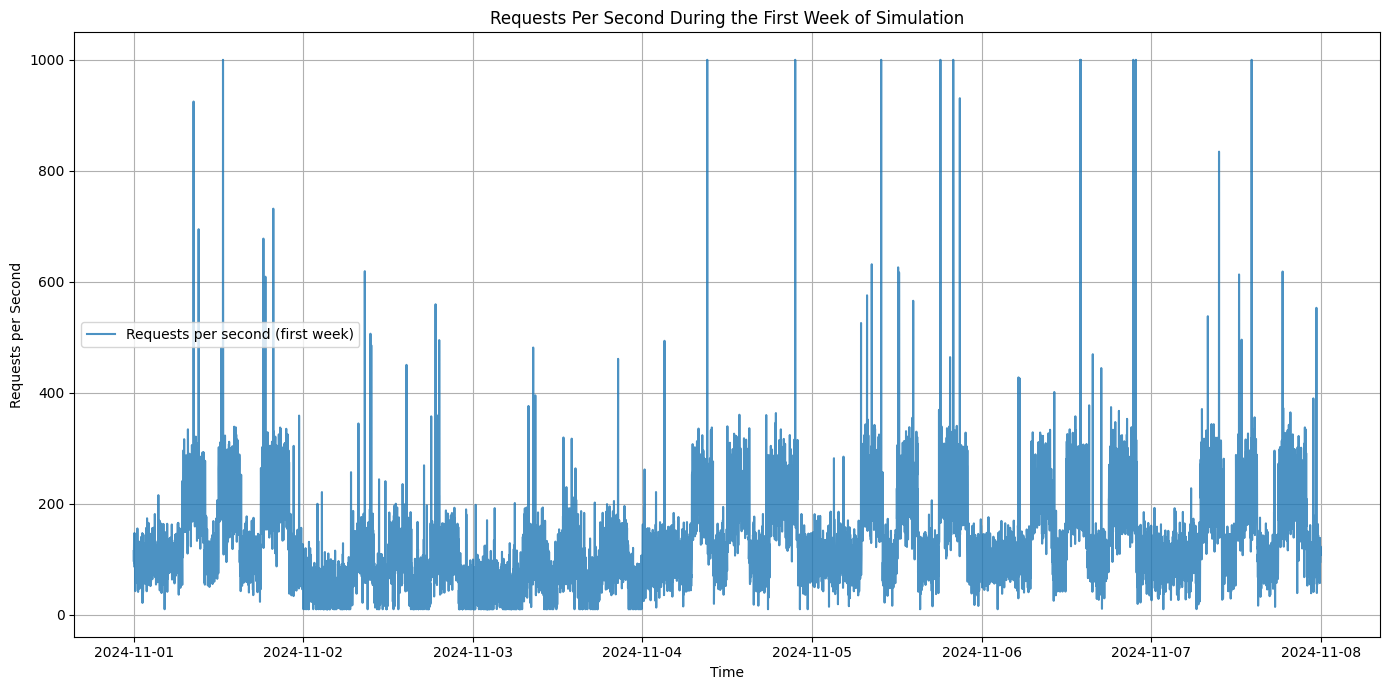

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import random

# Налаштування
np.random.seed(42)
start_time = dt.datetime(2024, 11, 1, 0, 0)  # Початок місяця
time_steps = 4 * 7 * 24 * 60  # 4 тижні, кожна хвилина
time_interval = pd.date_range(start=start_time, periods=time_steps, freq='T')

# Генерація метрик з урахуванням більшої варіативності
requests_per_second = []
for timestamp in time_interval:
    # Базове навантаження змінюється залежно від дня тижня
    base_load = 50 if timestamp.weekday() >= 5 else 100  # Вихідні дні мають нижче навантаження

    # Пікові години (7-9 ранку, 12-14 обід, 18-21 вечора)
    hour = timestamp.hour
    if 7 <= hour <= 9 or 12 <= hour <= 14 or 18 <= hour <= 21:
        base_load *= np.random.uniform(1.5, 3)  # Випадкове збільшення у пікові години

    # Сезонність (навантаження змінюється залежно від тижнів)
    week_of_month = (timestamp.day - 1) // 7
    if week_of_month == 2:  # Наприклад, тиждень акцій
        base_load *= np.random.uniform(1.2, 1.5)

    # Додавання випадкових аномалій (наприклад, раптовий сплеск навантаження)
    if random.random() < 0.01:  # 1% ймовірності аномалії
        base_load *= np.random.uniform(2, 5)

    # Додавання шуму
    rps = np.clip(base_load + np.random.normal(0, 30), 10, 1000)
    requests_per_second.append(rps)

# Додаткові параметри
days_of_week = [date.weekday() for date in time_interval]  # День тижня (0 = Пн, 6 = Нд)
days_of_month = [date.day for date in time_interval]  # День місяця
is_holiday = [1 if random.random() < 0.05 else 0 for _ in range(time_steps)]  # Свято (5% випадково)

# Формування DataFrame
data = {
    'timestamp': time_interval,
    'requests_per_second': requests_per_second,
    'day_of_week': days_of_week,
    'day_of_month': days_of_month,
    'is_holiday': is_holiday
}
df_varied = pd.DataFrame(data)

# Збереження до CSV
df_varied.to_csv('simulated_varied_data.csv', index=False)

# Візуалізація
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(df_varied['timestamp'][:7*24*60], df_varied['requests_per_second'][:7*24*60], label='Requests per second (first week)', alpha=0.8)
plt.title('Requests Per Second During the First Week of Simulation')
plt.xlabel('Time')
plt.ylabel('Requests per Second')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#Create Model


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:
# Завантаження датасету
df = pd.read_csv('simulated_varied_data.csv', parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

# Вибір лише однієї метрики для прогнозування (наприклад, requests_per_second)
data = df['requests_per_second'].values.reshape(-1, 1)

# Масштабування даних до [0, 1] для покращення навчання
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Формування послідовностей для LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Наприклад, 60 хвилин історії для прогнозу наступного значення
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Розділення даних на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Створення моделі
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Прогнозуємо одне значення
])

# Компіляція моделі
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Навчання
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 139s 134ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 2/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 140s 133ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 3/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 133s 132ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 4/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 140s 130ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 5/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 147s 135ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 6/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 134s 133ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 7/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 142s 133ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 8/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 144s 135ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 9/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 138s 132ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 10/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 140s 130ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 11/20
1007/1007 ━━━━━━━━━━━━━━━━━━━━ 144s 132ms/step - loss: 0.0038 - val

In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

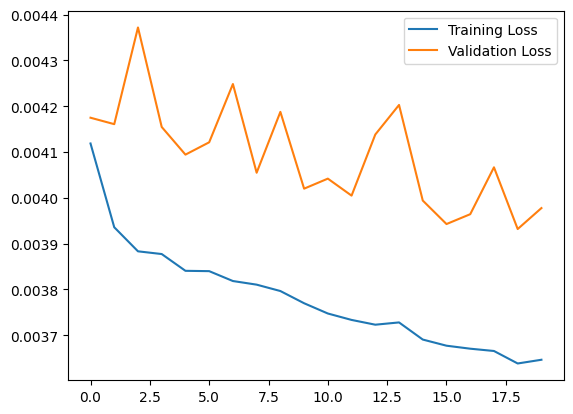

252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step


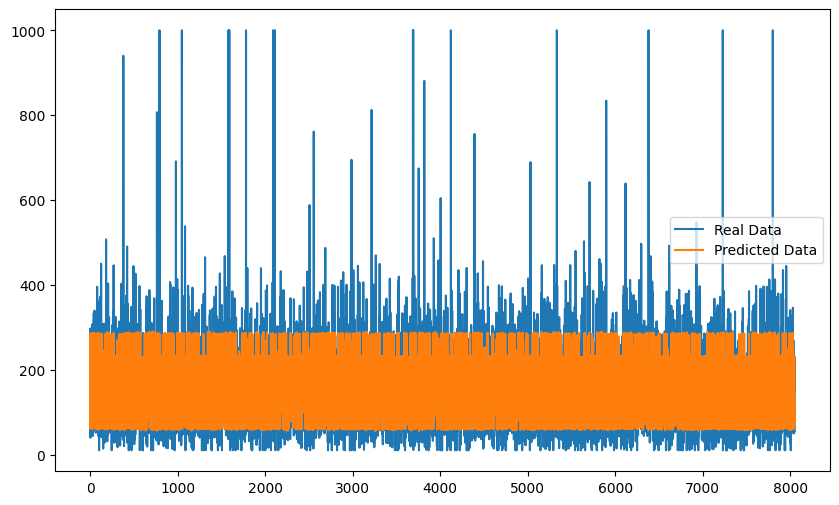

In [ ]:
# Оцінка втрат під час навчання
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Прогнозування на тестовому наборі
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)  # Перетворення назад до початкового масштабу
y_test_rescaled = scaler.inverse_transform(y_test)

# Візуалізація реальних і передбачених значень
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Real Data')
plt.plot(y_pred_rescaled, label='Predicted Data')
plt.legend()
plt.show()


In [ ]:
# Прогнозування нового значення
def predict_next(data, model, scaler, seq_length):
    last_sequence = data[-seq_length:]  # Останнє вікно для прогнозу
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))
    prediction = model.predict(last_sequence_scaled.reshape(1, seq_length, 1))
    return scaler.inverse_transform(prediction)[0, 0]

# Приклад: прогнозування наступного значення
next_value = predict_next(data, model, scaler, SEQ_LENGTH)
print(f"Прогнозоване значення для наступного часу: {next_value}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Прогнозоване значення для наступного часу: 99.45093536376953


In [ ]:
#ТЕСТУВАННЯ

# Прогнозування нового значення
def predict_next(data, model, scaler, seq_length):
    last_sequence = data[-seq_length:]  # Останнє вікно для прогнозу
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))
    print(last_sequence_scaled)
    prediction = model.predict(last_sequence_scaled.reshape(1, seq_length, 1))
    return scaler.inverse_transform(prediction)[0, 0]

# Приклад: прогнозування наступного значення
next_value = predict_next(data, model, scaler, SEQ_LENGTH)
print(f"Прогнозоване значення для наступного часу: {next_value}")

[[0.10894758]
 [0.05891802]
 [0.10666444]
 [0.11378167]
 [0.14172302]
 [0.10863594]
 [0.12428836]
 [0.10958471]
 [0.04984938]
 [0.11604196]
 [0.44903516]
 [0.10846664]
 [0.0216247 ]
 [0.09662281]
 [0.12756536]
 [0.06300267]
 [0.05767806]
 [0.10128306]
 [0.05616096]
 [0.1252597 ]
 [0.07529848]
 [0.11145516]
 [0.06326852]
 [0.15209679]
 [0.15782499]
 [0.1250724 ]
 [0.07021775]
 [0.08879435]
 [0.03099211]
 [0.13049043]
 [0.0944759 ]
 [0.08820935]
 [0.06357557]
 [0.12079143]
 [0.10723872]
 [0.09228274]
 [0.10394452]
 [0.14943971]
 [0.06333702]
 [0.05278958]
 [0.06724405]
 [0.12733125]
 [0.09939346]
 [0.06755476]
 [0.10687373]
 [0.07586002]
 [0.09619464]
 [0.10527718]
 [0.07246989]
 [0.03588122]
 [0.09823009]
 [0.08503635]
 [0.0721304 ]
 [0.09839104]
 [0.10978104]
 [0.02486362]
 [0.09415529]
 [0.08734492]
 [0.20668239]
 [0.03579877]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Прогнозоване значення для наступного часу: 99.45093536376953
